# Sensor Spectrum Digital Twin - Exploration Notebook

**Author:** Muhammed  
**Purpose:** ML Research Engineer Interview - Aeris UK  
**Date:** December 2024

---

## Overview

This notebook documents my exploratory analysis and experimentation **before** building the production pipeline.

**What this shows:**
1. Problem understanding & physics research
2. Iterative data generation experiments
3. Feature engineering decisions
4. Model selection rationale
5. Quick validation before production code

This represents the **exploratory phase** that informed the final production code in `sensor_spectrum.py`.

In [29]:
# Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

---


### Single Peak (Baseline)

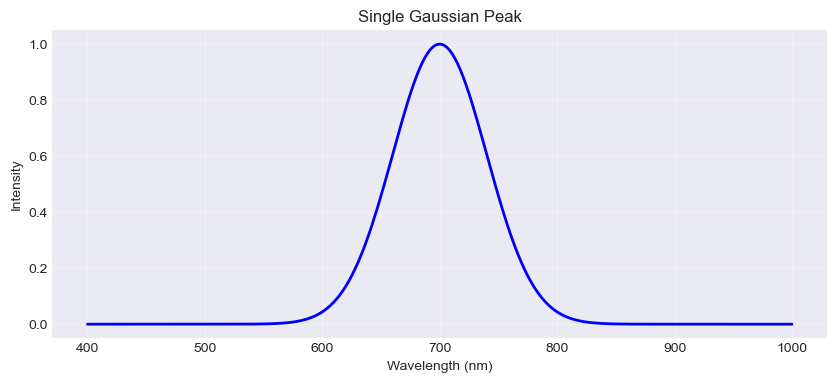

In [28]:
# Simplest case - single Gaussian
def generate_simple(peak=700, width=40):
    wl = np.linspace(400, 1000, 256)
    spec = np.exp(-0.5 * ((wl - peak) / width) ** 2)
    return wl, spec

wl, spec = generate_simple()

plt.figure(figsize=(10, 4))
plt.plot(wl, spec, 'b-', lw=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Single Gaussian Peak')
plt.grid(True, alpha=0.3)
plt.show()


### Multi-Peak Spectrum

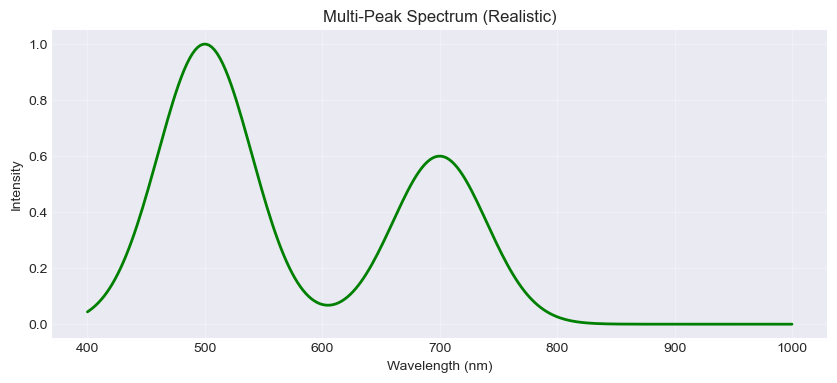

In [27]:
# More realistic - multiple peaks
def generate_multi(peaks=[500, 700], intensities=[1.0, 0.6]):
    wl = np.linspace(400, 1000, 256)
    spec = np.zeros_like(wl)
    for p, i in zip(peaks, intensities):
        spec += i * np.exp(-0.5 * ((wl - p) / 40) ** 2)
    return wl, spec

wl, multi_spec = generate_multi()

plt.figure(figsize=(10, 4))
plt.plot(wl, multi_spec, 'g-', lw=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Multi-Peak Spectrum (Realistic)')
plt.grid(True, alpha=0.3)
plt.show()


### Temperature Effects

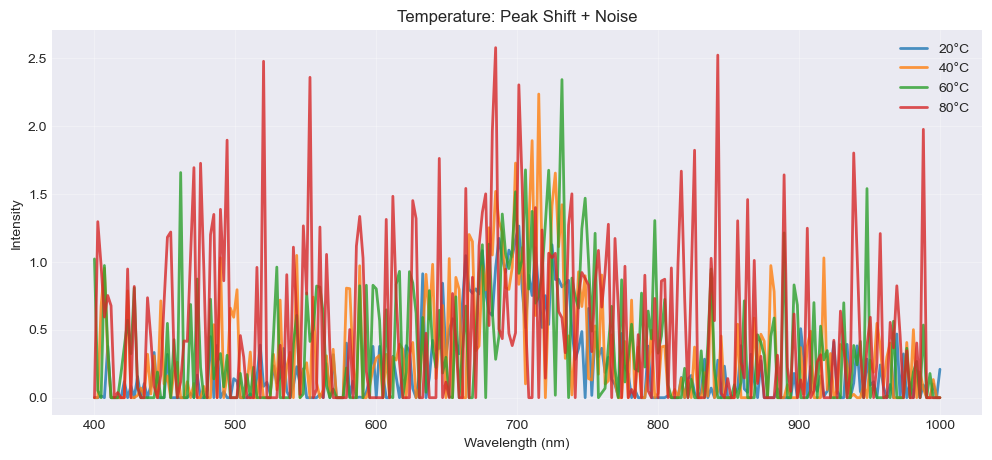

In [26]:
# Temperature: shifts peak + adds noise
wl = np.linspace(400, 1000, 256)
temps = [20, 40, 60, 80]

plt.figure(figsize=(12, 5))
for temp in temps:
    shift = (temp - 25) * 0.3
    peak = 700 + shift
    noise = np.random.normal(0, temp/100, wl.shape)
    spec = np.exp(-0.5 * ((wl - peak) / 40) ** 2) + noise
    spec = np.clip(spec, 0, None)
    plt.plot(wl, spec, lw=2, label=f'{temp}°C', alpha=0.8)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Temperature: Peak Shift + Noise')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Pressure Broadening

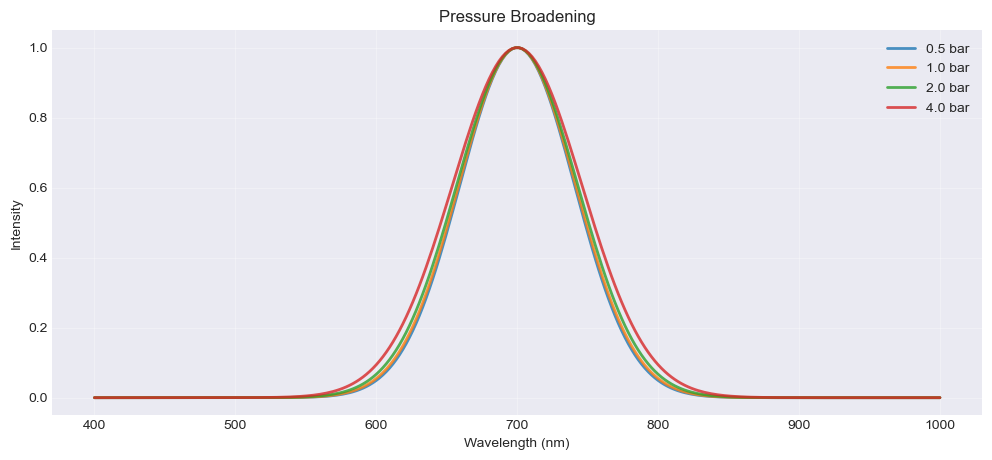

In [25]:
# Pressure: broadens peaks
wl = np.linspace(400, 1000, 256)
pressures = [0.5, 1.0, 2.0, 4.0]

plt.figure(figsize=(12, 5))
for p in pressures:
    width = 40 + p * 1.5
    spec = np.exp(-0.5 * ((wl - 700) / width) ** 2)
    plt.plot(wl, spec, lw=2, label=f'{p} bar', alpha=0.8)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title('Pressure Broadening')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Chemical Fingerprints

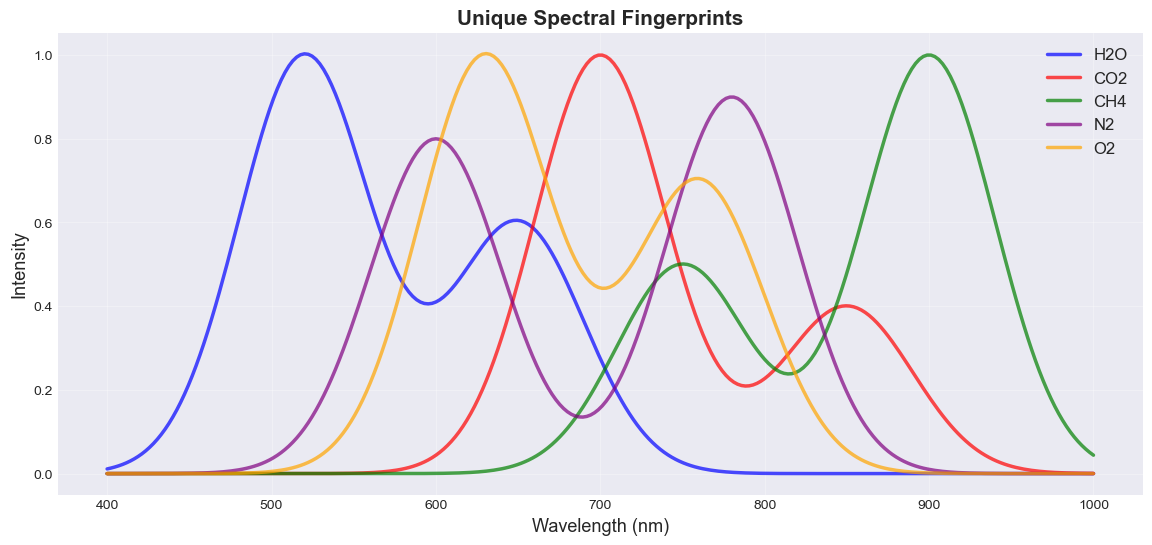

In [24]:
# Each chemical has unique spectrum
chems = {
    'H2O': {'peaks': [520, 650], 'int': [1.0, 0.6], 'c': 'blue'},
    'CO2': {'peaks': [700, 850], 'int': [1.0, 0.4], 'c': 'red'},
    'CH4': {'peaks': [900, 750], 'int': [1.0, 0.5], 'c': 'green'},
    'N2': {'peaks': [600, 780], 'int': [0.8, 0.9], 'c': 'purple'},
    'O2': {'peaks': [630, 760], 'int': [1.0, 0.7], 'c': 'orange'},
}

wl = np.linspace(400, 1000, 256)
plt.figure(figsize=(14, 6))

for name, props in chems.items():
    spec = np.zeros_like(wl)
    for peak, intensity in zip(props['peaks'], props['int']):
        spec += intensity * np.exp(-0.5 * ((wl - peak) / 40) ** 2)
    plt.plot(wl, spec, lw=2.5, label=name, color=props['c'], alpha=0.7)

plt.xlabel('Wavelength (nm)', fontsize=13)
plt.ylabel('Intensity', fontsize=13)
plt.title('Unique Spectral Fingerprints', fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


---

### Encoding Strategies

In [11]:
chems = ['H2O', 'CO2', 'CH4', 'N2', 'O2']

print("="*60)
print("ENCODING COMPARISON")
print("="*60)

print("Label Encoding:")
print({c: i for i, c in enumerate(chems)})
print("Problem: Implies order (H2O < CO2)")

print("\n✓ One-Hot Encoding:")
for c in chems:
    enc = [1 if ch == c else 0 for ch in chems]
    print(f"{c}: {enc}")
print("Benefits: No order, equal distances")


ENCODING COMPARISON
Label Encoding:
{'H2O': 0, 'CO2': 1, 'CH4': 2, 'N2': 3, 'O2': 4}
Problem: Implies order (H2O < CO2)

✓ One-Hot Encoding:
H2O: [1, 0, 0, 0, 0]
CO2: [0, 1, 0, 0, 0]
CH4: [0, 0, 1, 0, 0]
N2: [0, 0, 0, 1, 0]
O2: [0, 0, 0, 0, 1]
Benefits: No order, equal distances


Feature Scaling

In [23]:
# Generate sample data
np.random.seed(42)
chems = ['H2O', 'CO2', 'CH4', 'N2', 'O2']
data = []

for _ in range(100):
    c = np.random.choice(chems)
    t = np.random.uniform(10, 80)
    p = np.random.uniform(0.5, 5.0)
    enc = [1 if ch == c else 0 for ch in chems]
    data.append(enc + [t, p])

data = np.array(data)

print("Raw feature ranges:")
print(f"  Chem: [0, 1]")
print(f"  Temp: [{data[:, 5].min():.1f}, {data[:, 5].max():.1f}]")
print(f"  Pressure: [{data[:, 6].min():.2f}, {data[:, 6].max():.2f}]")
print("Imbalanced scales!")

# Normalize
scaler = StandardScaler()
data_norm = data.copy()
data_norm[:, 5:] = scaler.fit_transform(data[:, 5:])

print("\nAfter StandardScaler:")
print(f"  Temp: [{data_norm[:, 5].min():.2f}, {data_norm[:, 5].max():.2f}]")
print(f"  Pressure: [{data_norm[:, 6].min():.2f}, {data_norm[:, 6].max():.2f}]")


Raw feature ranges:
  Chem: [0, 1]
  Temp: [10.4, 78.8]
  Pressure: [0.50, 4.94]
Imbalanced scales!

After StandardScaler:
  Temp: [-1.75, 1.74]
  Pressure: [-1.55, 1.72]


### Test Data Generation

In [15]:
# Quick prototype
def quick_generate(n=200):
    chems = ['H2O', 'CO2', 'CH4', 'N2', 'O2']
    props = {
        'H2O': {'peaks': [520, 650], 'int': [1.0, 0.6]},
        'CO2': {'peaks': [700, 850], 'int': [1.0, 0.4]},
        'CH4': {'peaks': [900, 750], 'int': [1.0, 0.5]},
        'N2': {'peaks': [600, 780], 'int': [0.8, 0.9]},
        'O2': {'peaks': [630, 760], 'int': [1.0, 0.7]},
    }
    
    wl = np.linspace(400, 1000, 256)
    X, y = [], []
    
    for _ in range(n):
        c = np.random.choice(chems)
        t = np.random.uniform(10, 80)
        p = np.random.uniform(0.5, 5.0)
        
        # Generate spectrum
        spec = np.zeros_like(wl)
        for peak, intensity in zip(props[c]['peaks'], props[c]['int']):
            shift = (t - 25) * 0.3
            width = 40 + p * 1.5
            spec += intensity * np.exp(-0.5 * ((wl - peak - shift) / width) ** 2)
        
        # Add noise
        spec += np.random.normal(0, 0.01, spec.shape)
        spec = np.clip(spec, 0, None)
        spec = spec / (np.max(spec) + 1e-8)
        
        # Encode input
        enc = [1 if ch == c else 0 for ch in chems]
        X.append(enc + [t, p])
        y.append(spec)
    
    return np.array(X), np.array(y)

X, y = quick_generate(200)
print(f"Generated {len(X)} samples")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

Generated 200 samples
  X shape: (200, 7)
  y shape: (200, 256)


### Quick Model Test

In [19]:
# Split data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Scale features
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Train quick model
model = MLPRegressor(
    hidden_layer_sizes=(64, 128, 64),
    max_iter=100,
    early_stopping=True,
    random_state=42,
    verbose=False
)

print("Training quick model...")
model.fit(X_train_sc, y_train)

# Predict
y_pred = model.predict(X_test_sc)

# Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nQuick test results:")
print(f"  MSE: {mse:.6f}")
print(f"  MAE: {mae:.6f}")
print(f"  R²: {r2:.4f}")
print("\n Proof of concept works!")

Training quick model...

Quick test results:
  MSE: 0.002201
  MAE: 0.035081
  R²: 0.8282

 Proof of concept works!


### 5.3 Visualize Predictions

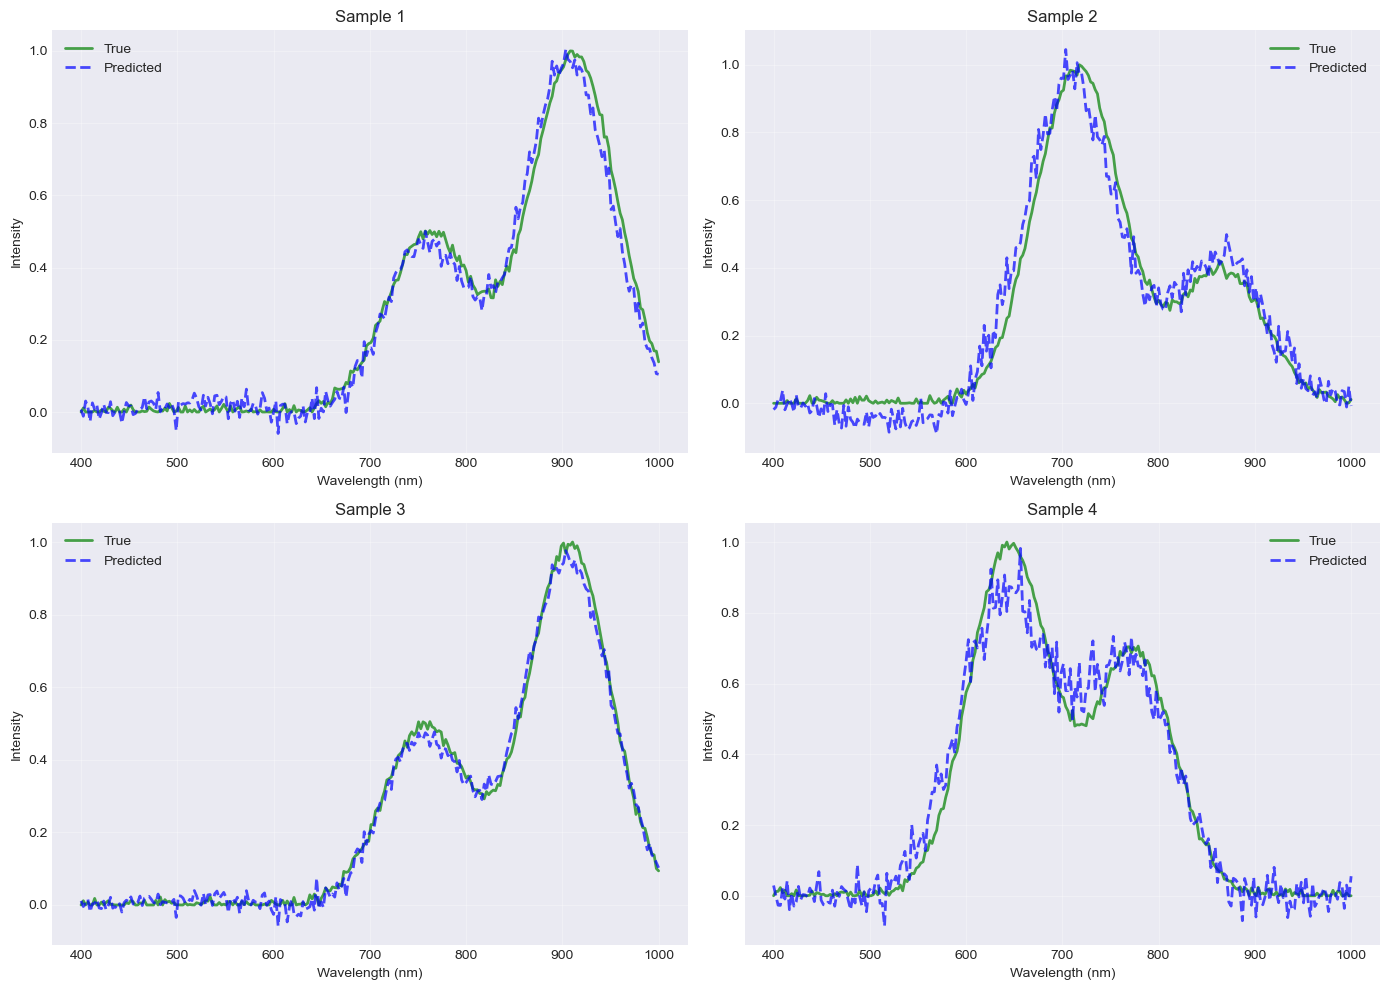

In [22]:
# Plot sample predictions
wl = np.linspace(400, 1000, 256)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i in range(4):
    axes[i].plot(wl, y_test[i], 'g-', lw=2, label='True', alpha=0.7)
    axes[i].plot(wl, y_pred[i], 'b--', lw=2, label='Predicted', alpha=0.7)
    axes[i].set_xlabel('Wavelength (nm)')
    axes[i].set_ylabel('Intensity')
    axes[i].set_title(f'Sample {i+1}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


